In [1]:
%matplotlib inline
import numpy
import adl.interpreter

In [2]:
run = adl.interpreter.Run("""
count "histogram" by
  regular(100, -5, 5) <- x
""")
run(x = numpy.random.normal(0, 1, 1000));

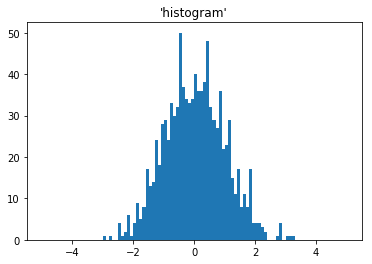

In [3]:
run["histogram"].plot()